In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re
from nltk.probability import FreqDist
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Load bug data

In [2]:
pd.set_option=("display.max_colwidth",'100')

df1=pd.read_csv("../../fx_bug_data.csv")
df1.tail()

,bug_id,type,summary,product,component,assignee,status,resolution,updated_date,priority,component_id
9995,1740499,defect,[fission] Page loads flickers and shows visibl...,Core,layout,nobody,NEW,---,2022-01-04,P2,NaN
9996,1602034,defect,Typing 3 numbers separated by . into address b...,Core,dom,nobody,UNCONFIRMED,---,2020-10-02,P5,NaN
9997,733835,defect,When typing into a contentEditable span when s...,Core,dom,nobody,UNCONFIRMED,---,2020-12-16,P5,NaN
9998,1590705,defect,LRE is causing text to overflow,Core,layout,nobody,UNCONFIRMED,---,2019-10-24,P3,NaN
9999,1484159,defect,WebGL texture fail with png containing gAMA ch...,Core,canvas,nobody,UNCONFIRMED,---,2019-02-21,P3,NaN


## Drop unnecessary columns

In [3]:
df2=df1.drop(['type','resolution','status','assignee','priority','component_id'],axis=1)
#df2=df1.drop(['type','resolution','status','assignee'],axis=1)
df2['summary']=df2['summary'].str.lower()
df2.head()
df3=df2
df3

,bug_id,summary,product,component,updated_date
0,1552155,navigator does not free preference hash table ...,Air Mozilla,layout,2019-05-16
1,1468907,[wayland] glcontextegl::swapbuffers() races pa...,Core,widget,2019-05-30
2,1596723,buttons in the search in touch bar feature som...,Core,cocoa,2022-01-03
3,941343,[ux] ui design: operator dashboard communicati...,Tracking,bugzilla,2015-12-23
4,1338813,mouse scroll icon invisible in firefox full-sc...,Core,win32,2018-11-05
...,...,...,...,...,...
9995,1740499,[fission] page loads flickers and shows visibl...,Core,layout,2022-01-04
9996,1602034,typing 3 numbers separated by . into address b...,Core,dom,2020-10-02
9997,733835,when typing into a contenteditable span when s...,Core,dom,2020-12-16
9998,1590705,lre is causing text to overflow,Core,layout,2019-10-24


## Removing punctuations from the summary

In [4]:
#removing punctuations from the summary

import string

string.punctuation

#creating a function
def remove_punctuation(txt):
    txt_nopunt="".join([c for c in txt if c not in string.punctuation])
    return txt_nopunt

df3['msg_clean']=df3['summary'].apply(lambda x:remove_punctuation(x))
df3

,bug_id,summary,product,component,updated_date,msg_clean
0,1552155,navigator does not free preference hash table ...,Air Mozilla,layout,2019-05-16,navigator does not free preference hash table ...
1,1468907,[wayland] glcontextegl::swapbuffers() races pa...,Core,widget,2019-05-30,wayland glcontexteglswapbuffers races patch se...
2,1596723,buttons in the search in touch bar feature som...,Core,cocoa,2022-01-03,buttons in the search in touch bar feature som...
3,941343,[ux] ui design: operator dashboard communicati...,Tracking,bugzilla,2015-12-23,ux ui design operator dashboard communication pad
4,1338813,mouse scroll icon invisible in firefox full-sc...,Core,win32,2018-11-05,mouse scroll icon invisible in firefox fullscr...
...,...,...,...,...,...,...
9995,1740499,[fission] page loads flickers and shows visibl...,Core,layout,2022-01-04,fission page loads flickers and shows visible ...
9996,1602034,typing 3 numbers separated by . into address b...,Core,dom,2020-10-02,typing 3 numbers separated by into address ba...
9997,733835,when typing into a contenteditable span when s...,Core,dom,2020-12-16,when typing into a contenteditable span when s...
9998,1590705,lre is causing text to overflow,Core,layout,2019-10-24,lre is causing text to overflow


## Tokenize the summary

In [5]:
import re

def tokenize(text):
    tokens=re.split('\W+',text)
    return tokens

df3['summary_tokenized']=df3['msg_clean'].apply(lambda x: tokenize(x.lower()))
df3

,bug_id,summary,product,component,updated_date,msg_clean,summary_tokenized
0,1552155,navigator does not free preference hash table ...,Air Mozilla,layout,2019-05-16,navigator does not free preference hash table ...,"[navigator, does, not, free, preference, hash,..."
1,1468907,[wayland] glcontextegl::swapbuffers() races pa...,Core,widget,2019-05-30,wayland glcontexteglswapbuffers races patch se...,"[wayland, glcontexteglswapbuffers, races, patc..."
2,1596723,buttons in the search in touch bar feature som...,Core,cocoa,2022-01-03,buttons in the search in touch bar feature som...,"[buttons, in, the, search, in, touch, bar, fea..."
3,941343,[ux] ui design: operator dashboard communicati...,Tracking,bugzilla,2015-12-23,ux ui design operator dashboard communication pad,"[ux, ui, design, operator, dashboard, communic..."
4,1338813,mouse scroll icon invisible in firefox full-sc...,Core,win32,2018-11-05,mouse scroll icon invisible in firefox fullscr...,"[mouse, scroll, icon, invisible, in, firefox, ..."
...,...,...,...,...,...,...,...
9995,1740499,[fission] page loads flickers and shows visibl...,Core,layout,2022-01-04,fission page loads flickers and shows visible ...,"[fission, page, loads, flickers, and, shows, v..."
9996,1602034,typing 3 numbers separated by . into address b...,Core,dom,2020-10-02,typing 3 numbers separated by into address ba...,"[typing, 3, numbers, separated, by, into, addr..."
9997,733835,when typing into a contenteditable span when s...,Core,dom,2020-12-16,when typing into a contenteditable span when s...,"[when, typing, into, a, contenteditable, span,..."
9998,1590705,lre is causing text to overflow,Core,layout,2019-10-24,lre is causing text to overflow,"[lre, is, causing, text, to, overflow]"


## Remove stop-words

In [6]:
#importing nltk to remove stopwords from the summary_tokenized

import nltk
nltk.download('stopwords')
stopwords=nltk.corpus.stopwords.words('english')

def remove_stopwords(txt_tokenized):
    txt_clean=[word for word in txt_tokenized if word not in stopwords]
    return txt_clean


df3['no_swds']=df3['summary_tokenized'].apply(lambda x: remove_stopwords(x))
df3

[nltk_data] Downloading package stopwords to /home/taj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,bug_id,summary,product,component,updated_date,msg_clean,summary_tokenized,no_swds
0,1552155,navigator does not free preference hash table ...,Air Mozilla,layout,2019-05-16,navigator does not free preference hash table ...,"[navigator, does, not, free, preference, hash,...","[navigator, free, preference, hash, table, exit]"
1,1468907,[wayland] glcontextegl::swapbuffers() races pa...,Core,widget,2019-05-30,wayland glcontexteglswapbuffers races patch se...,"[wayland, glcontexteglswapbuffers, races, patc...","[wayland, glcontexteglswapbuffers, races, patc..."
2,1596723,buttons in the search in touch bar feature som...,Core,cocoa,2022-01-03,buttons in the search in touch bar feature som...,"[buttons, in, the, search, in, touch, bar, fea...","[buttons, search, touch, bar, feature, sometim..."
3,941343,[ux] ui design: operator dashboard communicati...,Tracking,bugzilla,2015-12-23,ux ui design operator dashboard communication pad,"[ux, ui, design, operator, dashboard, communic...","[ux, ui, design, operator, dashboard, communic..."
4,1338813,mouse scroll icon invisible in firefox full-sc...,Core,win32,2018-11-05,mouse scroll icon invisible in firefox fullscr...,"[mouse, scroll, icon, invisible, in, firefox, ...","[mouse, scroll, icon, invisible, firefox, full..."
...,...,...,...,...,...,...,...,...
9995,1740499,[fission] page loads flickers and shows visibl...,Core,layout,2022-01-04,fission page loads flickers and shows visible ...,"[fission, page, loads, flickers, and, shows, v...","[fission, page, loads, flickers, shows, visibl..."
9996,1602034,typing 3 numbers separated by . into address b...,Core,dom,2020-10-02,typing 3 numbers separated by into address ba...,"[typing, 3, numbers, separated, by, into, addr...","[typing, 3, numbers, separated, address, bar, ..."
9997,733835,when typing into a contenteditable span when s...,Core,dom,2020-12-16,when typing into a contenteditable span when s...,"[when, typing, into, a, contenteditable, span,...","[typing, contenteditable, span, selection, nbs..."
9998,1590705,lre is causing text to overflow,Core,layout,2019-10-24,lre is causing text to overflow,"[lre, is, causing, text, to, overflow]","[lre, causing, text, overflow]"


## Lemmatize words

In [7]:
from nltk.corpus import wordnet
import nltk
import re

nltk.download('wordnet')
nltk.download('omw-1.4')
wn = nltk.WordNetLemmatizer()

# Define a function to check if a word has a dictionary meaning. Input: word
def word_has_dictionary_meaning(word):
    synsets = wordnet.synsets(word)
    return len(synsets) > 0

# Input: array of words as token
def clean_numbers(token_txt):
    number_pattern = r'^-?\d+$'
    text = [word for word in token_txt if not re.match(number_pattern, word)]
    return text

# Define a function to lemmatize words. Input: array of words as token
def lemmatization(token_txt):
    text = [wn.lemmatize(word) for word in token_txt]
    return text

# Apply the lemmatization function to the 'no_swds' column
df3['filtered_no_swds'] = df3['no_swds'].apply(lambda words: [word for word in words if word_has_dictionary_meaning(word)])

df3['lemmatized_no_swds'] = df3['filtered_no_swds'].apply(lambda x: lemmatization(x))

df3['clean_lemma']=df3['lemmatized_no_swds'].apply(lambda words: clean_numbers(words))

df3

[nltk_data] Downloading package wordnet to /home/taj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/taj/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,bug_id,summary,product,component,updated_date,msg_clean,summary_tokenized,no_swds,filtered_no_swds,lemmatized_no_swds,clean_lemma
0,1552155,navigator does not free preference hash table ...,Air Mozilla,layout,2019-05-16,navigator does not free preference hash table ...,"[navigator, does, not, free, preference, hash,...","[navigator, free, preference, hash, table, exit]","[navigator, free, preference, hash, table, exit]","[navigator, free, preference, hash, table, exit]","[navigator, free, preference, hash, table, exit]"
1,1468907,[wayland] glcontextegl::swapbuffers() races pa...,Core,widget,2019-05-30,wayland glcontexteglswapbuffers races patch se...,"[wayland, glcontexteglswapbuffers, races, patc...","[wayland, glcontexteglswapbuffers, races, patc...","[wayland, races, patch, mp]","[wayland, race, patch, mp]","[wayland, race, patch, mp]"
2,1596723,buttons in the search in touch bar feature som...,Core,cocoa,2022-01-03,buttons in the search in touch bar feature som...,"[buttons, in, the, search, in, touch, bar, fea...","[buttons, search, touch, bar, feature, sometim...","[buttons, search, touch, bar, feature, sometim...","[button, search, touch, bar, feature, sometime...","[button, search, touch, bar, feature, sometime..."
3,941343,[ux] ui design: operator dashboard communicati...,Tracking,bugzilla,2015-12-23,ux ui design operator dashboard communication pad,"[ux, ui, design, operator, dashboard, communic...","[ux, ui, design, operator, dashboard, communic...","[design, operator, dashboard, communication, pad]","[design, operator, dashboard, communication, pad]","[design, operator, dashboard, communication, pad]"
4,1338813,mouse scroll icon invisible in firefox full-sc...,Core,win32,2018-11-05,mouse scroll icon invisible in firefox fullscr...,"[mouse, scroll, icon, invisible, in, firefox, ...","[mouse, scroll, icon, invisible, firefox, full...","[mouse, scroll, icon, invisible, windows, 10, ...","[mouse, scroll, icon, invisible, window, 10, t...","[mouse, scroll, icon, invisible, window, table..."
...,...,...,...,...,...,...,...,...,...,...,...
9995,1740499,[fission] page loads flickers and shows visibl...,Core,layout,2022-01-04,fission page loads flickers and shows visible ...,"[fission, page, loads, flickers, and, shows, v...","[fission, page, loads, flickers, shows, visibl...","[fission, page, loads, flickers, shows, visibl...","[fission, page, load, flicker, show, visible, ...","[fission, page, load, flicker, show, visible, ..."
9996,1602034,typing 3 numbers separated by . into address b...,Core,dom,2020-10-02,typing 3 numbers separated by into address ba...,"[typing, 3, numbers, separated, by, into, addr...","[typing, 3, numbers, separated, address, bar, ...","[typing, 3, numbers, separated, address, bar, ...","[typing, 3, number, separated, address, bar, a...","[typing, number, separated, address, bar, auto..."
9997,733835,when typing into a contenteditable span when s...,Core,dom,2020-12-16,when typing into a contenteditable span when s...,"[when, typing, into, a, contenteditable, span,...","[typing, contenteditable, span, selection, nbs...","[typing, span, selection, deleted, space, prec...","[typing, span, selection, deleted, space, prec...","[typing, span, selection, deleted, space, prec..."
9998,1590705,lre is causing text to overflow,Core,layout,2019-10-24,lre is causing text to overflow,"[lre, is, causing, text, to, overflow]","[lre, causing, text, overflow]","[causing, text, overflow]","[causing, text, overflow]","[causing, text, overflow]"


## Extract meaningful lemma

In [8]:
# Check if words were lemmatized
df3['lemmatized_check'] = df3.apply(lambda row: any(original != lemmatized for original, lemmatized in zip(row['no_swds'], row['lemmatized_no_swds'])), axis=1)

# Filter rows where lemmatization was applied
lemmatized_rows = df3[df3['lemmatized_check']]

# Display the rows where lemmatization was applied
print(lemmatized_rows[['no_swds', 'clean_lemma']])

                                                no_swds  \
1     [wayland, glcontexteglswapbuffers, races, patc...   
2     [buttons, search, touch, bar, feature, sometim...   
3     [ux, ui, design, operator, dashboard, communic...   
4     [mouse, scroll, icon, invisible, firefox, full...   
5     [inefficient, handing, node, 1000s, applied, r...   
...                                                 ...   
9995  [fission, page, loads, flickers, shows, visibl...   
9996  [typing, 3, numbers, separated, address, bar, ...   
9997  [typing, contenteditable, span, selection, nbs...   
9998                     [lre, causing, text, overflow]   
9999  [webgl, texture, fail, png, containing, gama, ...   

                                            clean_lemma  
1                            [wayland, race, patch, mp]  
2     [button, search, touch, bar, feature, sometime...  
3     [design, operator, dashboard, communication, pad]  
4     [mouse, scroll, icon, invisible, window, table...  
5

In [9]:
df3['meaningful_lemm_str'] = df3['clean_lemma'].apply(lambda x: ' '.join(x))

## Generate TF-IDF matrix from meaningful lemma strings

In [10]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Define stop words to remove them from TFIDF matrix
stop = list(stopwords.words('english'))
stop.extend(['10','13','30','60','firefox','doesnt','using','user','use','new','zoomoutcur','x','xx','xxx','xxxx', 
             'xyz','äöü','类型','更新10101之后','没有找到支持的视频格式和','类','型','1st','2d','2nd','3d','3rd','aa','dd'])

# Update the word_to_drop list with the extended stopwords
word_to_drop = stop

# Create an instance of TfidfVectorizer with stop words
vectorizer = TfidfVectorizer(stop_words=word_to_drop, min_df=25, max_features=20000)

# Fit and transform your text data using the vectorizer
tfidf_matrix = vectorizer.fit_transform(df3['meaningful_lemm_str'])

# Apply threshold on TF-IDF values
min_threshold = 0.05  # example value
max_threshold = 0.8  # example value

# Set values below min_threshold to 0 and values above max_threshold to max_threshold
tfidf_matrix = tfidf_matrix.todense()  # Convert sparse matrix to dense
tfidf_matrix[tfidf_matrix < min_threshold] = 0
tfidf_matrix[tfidf_matrix > max_threshold] = max_threshold

# Get the feature names (i.e., words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Iterate over feature names and their corresponding TF-IDF scores for each document
for i in range(len(df3)):
    print(f"Document {i+1}:")
    for j, word in enumerate(feature_names):
        tfidf_score = tfidf_matrix[i, j]
        if tfidf_score > 0.3:
            print(f"{word}: {tfidf_score:.4f}")

Document 1:
preference: 0.7366
table: 0.6763
Document 2:
wayland: 0.8000
Document 3:
bar: 0.3024
feature: 0.3969
label: 0.4095
missing: 0.3383
search: 0.3402
sometimes: 0.3191
touch: 0.4116
Document 4:
design: 0.8000
Document 5:
icon: 0.4200
invisible: 0.5200
mode: 0.3717
mouse: 0.4123
scroll: 0.4091
Document 6:
applied: 0.6151
node: 0.5592
rule: 0.5559
Document 7:
external: 0.5259
loading: 0.4622
reset: 0.5427
script: 0.4639
Document 8:
certificate: 0.5364
client: 0.5623
fails: 0.4441
load: 0.4461
Document 9:
color: 0.7846
video: 0.6200
Document 10:
feature: 0.8000
Document 11:
address: 0.5777
network: 0.5728
panel: 0.5816
Document 12:
glitch: 0.5273
true: 0.5473
video: 0.3459
visual: 0.5502
Document 13:
refresh: 0.7771
working: 0.6294
Document 14:
may: 0.8000
work: 0.5590
Document 15:
notification: 0.5103
option: 0.4629
permission: 0.5410
window: 0.3110
work: 0.3688
Document 16:
change: 0.5616
page: 0.4310
printing: 0.7063
Document 17:
attribute: 0.5880
even: 0.5526
table: 0.5906
Doc

failed: 0.5148
fails: 0.4284
page: 0.3310
Document 1149:
scrolling: 0.5147
specific: 0.6697
website: 0.5353
Document 1150:
background: 0.4638
blank: 0.4844
left: 0.5383
playing: 0.5105
Document 1151:
load: 0.5427
page: 0.4174
slower: 0.7289
Document 1152:
item: 0.3305
size: 0.8000
Document 1153:
error: 0.3985
failing: 0.6152
get: 0.4607
search: 0.5005
Document 1154:
method: 0.7963
test: 0.6048
Document 1155:
extension: 0.3674
preference: 0.4212
properly: 0.3661
search: 0.7441
Document 1156:
value: 0.8000
Document 1157:
broken: 0.6572
preview: 0.7537
Document 1158:
cause: 0.7833
property: 0.4598
value: 0.4184
Document 1159:
crash: 0.8000
Document 1160:
height: 0.6481
row: 0.3360
table: 0.5774
Document 1161:
blank: 0.3513
certain: 0.3754
height: 0.3994
scrolling: 0.3234
seems: 0.4064
size: 0.3369
space: 0.3712
Document 1162:
appear: 0.5579
permission: 0.5800
push: 0.5936
Document 1163:
incorrect: 0.7780
text: 0.6283
Document 1164:
broken: 0.3947
correctly: 0.3966
link: 0.3880
save: 0.435

option: 0.4714
properly: 0.4754
value: 0.4464
Document 2316:
cause: 0.3710
disappear: 0.5047
keyboard: 0.4297
password: 0.4017
pressing: 0.5115
Document 2317:
displaying: 0.8000
Document 2318:
active: 0.3432
preview: 0.3210
print: 0.3026
several: 0.3535
webpage: 0.3554
Document 2319:
browser: 0.4233
display: 0.4509
option: 0.4886
top: 0.5206
window: 0.3283
Document 2320:
authentication: 0.5445
close: 0.4969
leak: 0.5068
web: 0.4469
Document 2321:
device: 0.6054
name: 0.5745
properly: 0.5509
Document 2322:
area: 0.4204
drag: 0.3736
drop: 0.3614
focus: 0.3358
get: 0.3214
html: 0.3424
Document 2323:
working: 0.8000
Document 2324:
attribute: 0.7376
slow: 0.6752
Document 2325:
closing: 0.5456
dialog: 0.4620
print: 0.4914
problem: 0.4973
Document 2326:
effect: 0.8000
Document 2327:
content: 0.5558
resize: 0.8000
Document 2328:
problem: 0.7168
server: 0.6973
Document 2329:
canvas: 0.6292
large: 0.5890
set: 0.5071
Document 2330:
chrome: 0.5409
google: 0.5467
starting: 0.6391
Document 2331:
exp

test: 0.6526
Document 3515:
google: 0.5511
pixel: 0.6266
run: 0.5511
Document 3516:
inspector: 0.7045
search: 0.7097
Document 3517:
connection: 0.6047
freeze: 0.5919
sometimes: 0.5329
Document 3518:
broken: 0.5259
input: 0.4853
text: 0.4268
type: 0.5530
Document 3519:
available: 0.4019
break: 0.3361
missing: 0.3454
mode: 0.3034
reader: 0.4068
support: 0.3473
version: 0.3541
web: 0.3205
Document 3520:
bookmark: 0.4781
focus: 0.4590
open: 0.4083
view: 0.4800
wrong: 0.4045
Document 3521:
lost: 0.5507
selected: 0.5003
selection: 0.4623
table: 0.4823
Document 3522:
report: 0.8000
Document 3523:
longer: 0.8000
Document 3524:
button: 0.4986
render: 0.6216
version: 0.6042
Document 3525:
bar: 0.5031
black: 0.6086
title: 0.6136
Document 3526:
canvas: 0.6572
line: 0.5595
wrong: 0.5050
Document 3527:
instead: 0.4955
proxy: 0.5209
setting: 0.4847
system: 0.4982
Document 3528:
keyboard: 0.5547
navigation: 0.6359
setting: 0.5367
Document 3529:
change: 0.6905
password: 0.7233
Document 3530:
error: 0.6

dragging: 0.5642
trigger: 0.5642
Document 4713:
input: 0.8000
Document 4714:
cursor: 0.5820
loop: 0.6791
text: 0.4473
Document 4715:
content: 0.5574
page: 0.4679
view: 0.6859
Document 4716:
element: 0.8000
Document 4717:
button: 0.4704
element: 0.4325
focused: 0.6763
window: 0.3664
Document 4718:
Document 4719:
console: 0.4070
correct: 0.4958
log: 0.4797
object: 0.4101
state: 0.4362
Document 4720:
keyboard: 0.7536
mode: 0.6573
Document 4721:
cursor: 0.3676
dragging: 0.4117
image: 0.6281
mouse: 0.3488
pixel: 0.4233
Document 4722:
canvas: 0.6281
switch: 0.6616
tab: 0.4097
Document 4723:
address: 0.4869
different: 0.4788
form: 0.4959
saved: 0.5364
Document 4724:
already: 0.6020
block: 0.5246
updating: 0.6020
Document 4725:
black: 0.5016
browser: 0.3942
go: 0.5210
stop: 0.4776
window: 0.3057
Document 4726:
height: 0.5852
item: 0.5380
row: 0.6068
Document 4727:
add: 0.6666
image: 0.5861
page: 0.4607
Document 4728:
bad: 0.7574
performance: 0.6529
Document 4729:
file: 0.8000
Document 4730:
di

support: 0.7748
Document 5873:
character: 0.7882
file: 0.3082
printing: 0.4254
wrong: 0.3206
Document 5874:
content: 0.4437
unable: 0.5870
video: 0.4172
website: 0.5333
Document 5875:
large: 0.3485
print: 0.7065
properly: 0.3321
update: 0.3226
way: 0.4063
Document 5876:
keyboard: 0.5030
screen: 0.4364
second: 0.5162
wayland: 0.5385
Document 5877:
Document 5878:
leak: 0.8000
Document 5879:
button: 0.3505
disabled: 0.4360
flicker: 0.5040
sometimes: 0.3907
state: 0.4457
Document 5880:
directory: 0.6682
file: 0.4453
handle: 0.5960
Document 5881:
hardware: 0.6728
storage: 0.7399
Document 5882:
search: 0.8000
Document 5883:
update: 0.8000
Document 5884:
notification: 0.7465
request: 0.6654
Document 5885:
edit: 0.5598
font: 0.4104
incorrect: 0.4454
rendering: 0.4364
text: 0.3597
Document 5886:
beta: 0.6263
load: 0.4641
unresponsive: 0.6263
Document 5887:
Document 5888:
broken: 0.8000
Document 5889:
beta: 0.6443
icon: 0.5285
large: 0.5527
Document 5890:
allow: 0.5797
android: 0.5622
control: 0

email: 0.6917
result: 0.3048
sent: 0.3586
Document 7085:
clear: 0.6109
filter: 0.6109
icon: 0.5035
Document 7086:
caret: 0.4847
display: 0.3569
drag: 0.4242
drop: 0.4103
longer: 0.4387
text: 0.3114
Document 7087:
command: 0.4405
default: 0.3653
fails: 0.3325
line: 0.3517
opened: 0.3975
profile: 0.3901
update: 0.3579
Document 7088:
text: 0.8000
Document 7089:
certificate: 0.8000
Document 7090:
debugger: 0.5271
log: 0.5074
open: 0.3690
source: 0.4650
work: 0.3352
Document 7091:
missing: 0.6587
throw: 0.7524
Document 7092:
document: 0.7030
invalid: 0.7112
Document 7093:
error: 0.8000
Document 7094:
connection: 0.7936
event: 0.6084
Document 7095:
failure: 0.8000
Document 7096:
change: 0.5279
scroll: 0.5678
state: 0.6316
Document 7097:
font: 0.5046
show: 0.4926
size: 0.5542
text: 0.4423
Document 7098:
error: 0.3899
exception: 0.5370
memory: 0.4606
updating: 0.5895
Document 7099:
add: 0.7388
test: 0.6740
Document 7100:
add: 0.7388
test: 0.6740
Document 7101:
allow: 0.4793
developer: 0.4806
l

right: 0.3539
white: 0.3874
Document 8311:
image: 0.4758
information: 0.6530
need: 0.5893
Document 8312:
crash: 0.8000
Document 8313:
correctly: 0.5212
error: 0.8000
Document 8314:
current: 0.3400
preference: 0.3243
tab: 0.4123
url: 0.5323
Document 8315:
correctly: 0.4490
form: 0.4867
page: 0.3168
saved: 0.5265
url: 0.4289
Document 8316:
blank: 0.4661
opened: 0.4823
private: 0.5027
view: 0.4569
Document 8317:
allow: 0.3869
field: 0.3448
input: 0.6373
option: 0.3482
select: 0.3542
Document 8318:
high: 0.7060
message: 0.7082
Document 8319:
fire: 0.5266
key: 0.4800
value: 0.4583
window: 0.3251
wrong: 0.4203
Document 8320:
show: 0.8000
Document 8321:
call: 0.4946
open: 0.3956
send: 0.5683
throw: 0.5253
Document 8322:
low: 0.7790
position: 0.6270
Document 8323:
private: 0.3422
sidebar: 0.3639
state: 0.6618
sync: 0.3502
Document 8324:
page: 0.8000
Document 8325:
event: 0.4020
first: 0.5243
restart: 0.5680
system: 0.4908
Document 8326:
stop: 0.8000
Document 8327:
bar: 0.3717
cause: 0.3616
cli

element: 0.3687
inside: 0.5074
outside: 0.5827
space: 0.5168
Document 9406:
cause: 0.5031
memory: 0.5471
page: 0.3991
web: 0.5368
Document 9407:
content: 0.7129
find: 0.4888
site: 0.4041
Document 9408:
dark: 0.7265
find: 0.3517
navigation: 0.3605
theme: 0.3200
Document 9409:
deleting: 0.8000
event: 0.5552
Document 9410:
broken: 0.5252
cause: 0.4693
sync: 0.6143
window: 0.3557
Document 9411:
behavior: 0.4283
browser: 0.3152
event: 0.3043
function: 0.4010
keep: 0.4333
key: 0.3609
stop: 0.3818
Document 9412:
sometimes: 0.8000
Document 9413:
applied: 0.5747
font: 0.4257
rendering: 0.4527
still: 0.5324
Document 9414:
change: 0.7155
image: 0.6986
Document 9415:
crash: 0.8000
Document 9416:
button: 0.4313
download: 0.5638
file: 0.4176
manager: 0.5672
Document 9417:
even: 0.5488
list: 0.5497
menu: 0.4814
tab: 0.4061
Document 9418:
frame: 0.5868
loading: 0.5681
type: 0.5770
Document 9419:
animation: 0.6138
display: 0.5363
even: 0.5793
Document 9420:
color: 0.6909
different: 0.7230
Document 9421

## Generate elbow curve to determine numbe of clusters

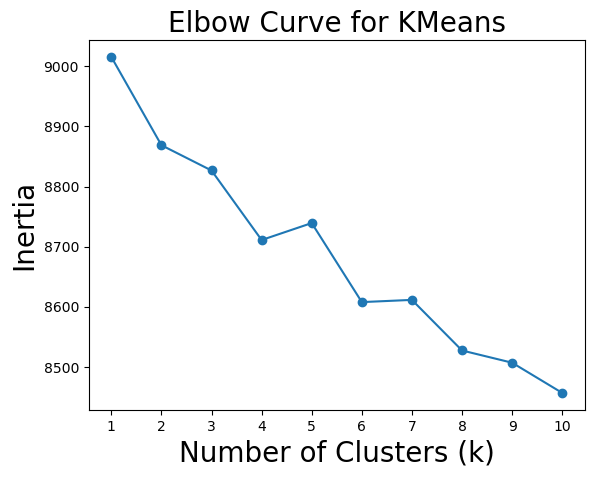

In [49]:
# elbow curve to determine the number of clusters

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define a range of cluster numbers to try
num_clusters_range = range(1, 11)  # You can adjust the range as needed

# Initialize a list to store the inertia values
inertia_values = []

n_init = 10

# Random state
random_state = 20

# Fit KMeans for each value of k and calculate inertia
for k in num_clusters_range:
    kmeans = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
    kmeans.fit(np.asarray(tfidf_matrix))
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(num_clusters_range, inertia_values, marker='o')
plt.title('Elbow Curve for KMeans', fontsize=20)
plt.xlabel('Number of Clusters (k)', fontsize=20)
plt.ylabel('Inertia', fontsize=20)
plt.xticks(num_clusters_range)
plt.show()

## K-Means Clustering

In [48]:
from sklearn.cluster import KMeans

# Define the number of clusters
num_clusters = 3

# Create an instance of KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, n_init=n_init, random_state=random_state)

# Fit the KMeans model to your TF-IDF matrix
kmeans.fit(np.asarray(tfidf_matrix))

# Get cluster labels for each document
cluster_labels = kmeans.labels_

# Print cluster assignments for the first 100 documents (for illustration)
#for i, label in enumerate(cluster_labels[:100]):  
#    print(f"Document {i+1} belongs to cluster {label}")


## Reduce dimensionality and plot clusters

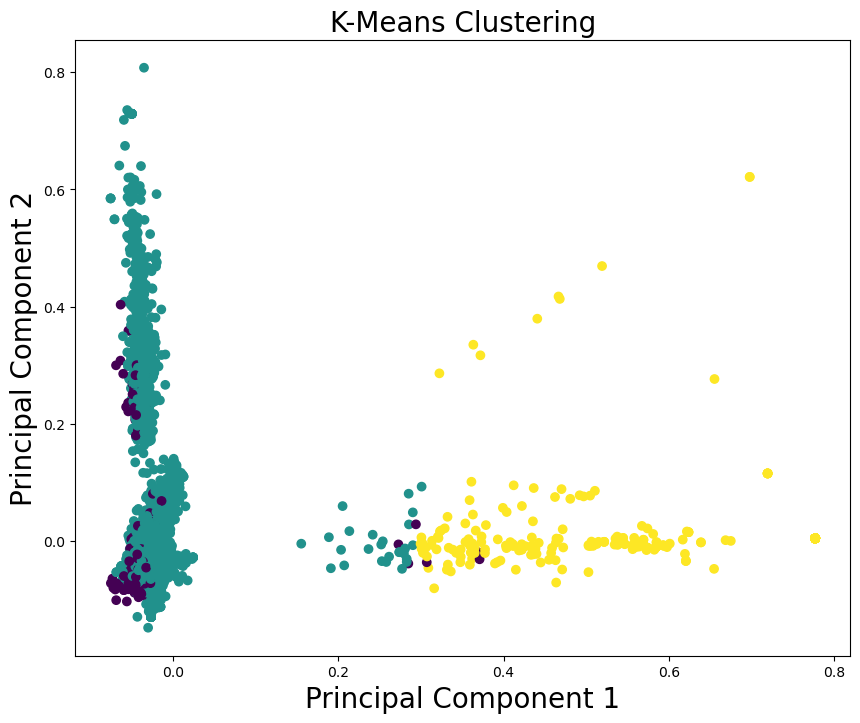

In [42]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(np.asarray(tfidf_matrix))

# Create a scatter plot of the clusters
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis')
plt.title('K-Means Clustering', fontsize=20)
plt.xlabel('Principal Component 1', fontsize=20)
plt.ylabel('Principal Component 2', fontsize=20)
plt.show()

In [94]:
from sklearn.cluster import KMeans

# create KMeans clustering object
kmeans = KMeans(n_clusters=num_clusters, random_state=random_state)

# fit KMeans clustering model to the tfidf_matrix
kmeans.fit(np.asarray(tfidf_matrix))

# get cluster labels for each row in the tfidf_matrix
df3['cluster_labels'] = kmeans.labels_

# print number of rows in each cluster
unique, counts = np.unique(cluster_labels, return_counts=True)
print(dict(zip(unique, counts)))


/Users/taj/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{0: 8984, 1: 365, 2: 651}


## Generate word-cloud

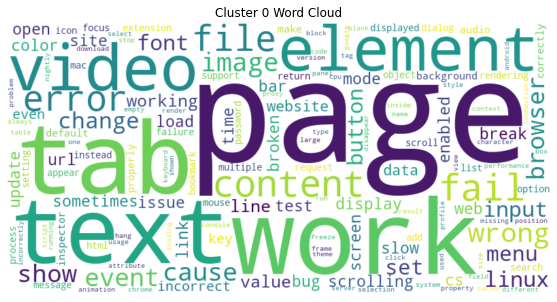

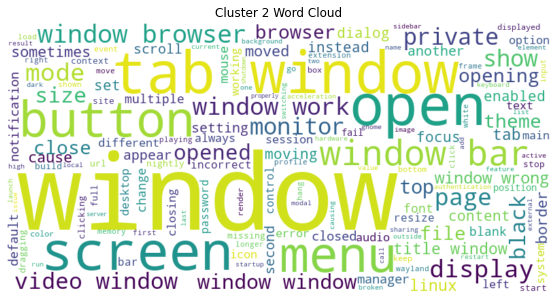

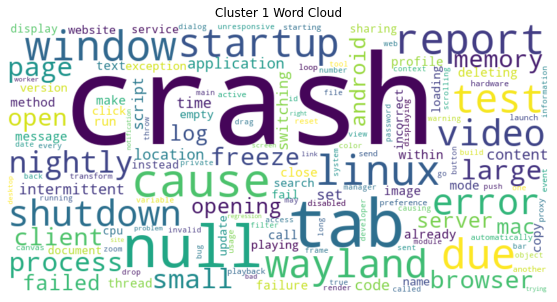

In [95]:
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Create a dictionary to store the documents in each cluster
cluster_docs = {}
for i, label in enumerate(cluster_labels):
    if label not in cluster_docs:
        cluster_docs[label] = []
    cluster_docs[label].append(i)

# Create word cloud for each cluster
for label, doc_indices in cluster_docs.items():
    # Retrieve the words from the TfidfVectorizer object
    cluster_words = " ".join(feature_names[i] for i in tfidf_matrix[doc_indices].nonzero()[1])

    # Check if cluster contains at least one document with words
    if cluster_words:
        # Create a WordCloud object
        wordcloud = WordCloud(width=800, height=400, max_words=150, background_color='white').generate(cluster_words)

        # Plot the WordCloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Cluster {label} Word Cloud')
        plt.axis('off')
        plt.show()
    else:
        print(f"No documents with words in Cluster {label}")



In [97]:

# Get the centroid vectors for each cluster
centroids = kmeans.cluster_centers_

# Get the indices of the most important features for each cluster
important_indices = centroids.argsort()[:, ::-1]

# Get the most important words for each cluster
num_words = 20
cluster_labels = {}
for i in range(num_clusters):
    label = f"Cluster {i+1}: "
    for j in range(num_words):
        label += feature_names[important_indices[i][j]] + ", "
    cluster_labels[i] = label[:-2]

# Print the cluster labels
for i, label in cluster_labels.items():
    print(label)



Cluster 1: page, video, tab, work, element, error, text, file, event, content, image, wrong, fails, failure, button, font, test, browser, menu, input
Cluster 2: crash, null, tab, cause, due, startup, linux, test, report, shutdown, wayland, window, large, small, nightly, video, error, process, freeze, client
Cluster 3: window, tab, browser, screen, open, bar, menu, button, display, monitor, work, mode, private, size, opened, black, show, video, title, top


In [144]:
df4=df3.drop(['msg_clean','summary_tokenized','no_swds','lemmatized','lemmatized_check','custom_lemmatized'],axis=1)
df4 

,summary,product,comp,updated,meaningful_lemm_str,cluster_labels,lemmatized_no_swds,filtered_no_swds,clean_lemma
0,firefox on ubuntu new tab crashes,Core,Widget: Gtk,2022-07-11,new tab crash,0,"[new, tab, crash]","[new, tab, crashes]","[new, tab, crash]"
1,enable fido ctap2 support in firefox nightly ...,Core,DOM: Web Authenticat,2022-10-26,enable support nightly,2,"[enable, support, nightly]","[enable, support, nightly]","[enable, support, nightly]"
2,firefox prompts two master password dialogs du...,Toolkit,Password Manager,2022-09-28,prompt two master password dialog startup,2,"[prompt, two, master, password, dialog, startup]","[prompts, two, master, password, dialogs, star...","[prompt, two, master, password, dialog, startup]"
3,global sharing indicator blocks access to menu...,Firefox,Site Permissions,2021-08-28,global sharing indicator block access menu,2,"[global, sharing, indicator, block, access, menu]","[global, sharing, indicator, blocks, access, m...","[global, sharing, indicator, block, access, menu]"
4,firefox prioritizes web socket events over loc...,Core,DOM: Networking,2021-11-16,prioritizes web socket event location change,2,"[prioritizes, web, socket, event, location, ch...","[prioritizes, web, socket, events, location, c...","[prioritizes, web, socket, event, location, ch..."
...,...,...,...,...,...,...,...,...,...
9995,add gradle support for building gecko binaries...,Firefox Build System,Android Studio and G,2022-10-11,add support building gecko binary,2,"[add, support, building, gecko, binary]","[add, support, building, gecko, binaries]","[add, support, building, gecko, binary]"
9996,changing the orientation after swiping left a ...,Firefox for iOS,Home screen,2022-10-11,changing orientation swiping left home panel i...,2,"[changing, orientation, swiping, left, home, p...","[changing, orientation, swiping, left, home, p...","[changing, orientation, swiping, left, home, p..."
9997,"incorrect focus on ""input"" name fields",Firefox,WebPayments UI,2022-10-11,incorrect focus input name field,2,"[incorrect, focus, input, name, field]","[incorrect, focus, input, name, fields]","[incorrect, focus, input, name, field]"
9998,enable sccache by default when available,Firefox Build System,General,2022-10-11,enable default available,2,"[enable, default, available]","[enable, default, available]","[enable, default, available]"


In [149]:
# Define a function to map cluster labels to cluster tags
def map_cluster_labels_to_tags(cluster_label):
    cluster_tags = {
        0: "User Interface",
        1: "Functional Performance Bugs",
        2: "Workflow Bugs"
       
    }
    return cluster_tags.get(cluster_label, "Other") 

df4['cluster_tag'] = df4['cluster_labels'].apply(map_cluster_labels_to_tags)

df4

,summary,product,comp,updated,meaningful_lemm_str,cluster_labels,lemmatized_no_swds,filtered_no_swds,clean_lemma,cluster_tag
0,firefox on ubuntu new tab crashes,Core,Widget: Gtk,2022-07-11,new tab crash,0,"[new, tab, crash]","[new, tab, crashes]","[new, tab, crash]",User Interface
1,enable fido ctap2 support in firefox nightly ...,Core,DOM: Web Authenticat,2022-10-26,enable support nightly,2,"[enable, support, nightly]","[enable, support, nightly]","[enable, support, nightly]",Workflow Bugs
2,firefox prompts two master password dialogs du...,Toolkit,Password Manager,2022-09-28,prompt two master password dialog startup,2,"[prompt, two, master, password, dialog, startup]","[prompts, two, master, password, dialogs, star...","[prompt, two, master, password, dialog, startup]",Workflow Bugs
3,global sharing indicator blocks access to menu...,Firefox,Site Permissions,2021-08-28,global sharing indicator block access menu,2,"[global, sharing, indicator, block, access, menu]","[global, sharing, indicator, blocks, access, m...","[global, sharing, indicator, block, access, menu]",Workflow Bugs
4,firefox prioritizes web socket events over loc...,Core,DOM: Networking,2021-11-16,prioritizes web socket event location change,2,"[prioritizes, web, socket, event, location, ch...","[prioritizes, web, socket, events, location, c...","[prioritizes, web, socket, event, location, ch...",Workflow Bugs
...,...,...,...,...,...,...,...,...,...,...
9995,add gradle support for building gecko binaries...,Firefox Build System,Android Studio and G,2022-10-11,add support building gecko binary,2,"[add, support, building, gecko, binary]","[add, support, building, gecko, binaries]","[add, support, building, gecko, binary]",Workflow Bugs
9996,changing the orientation after swiping left a ...,Firefox for iOS,Home screen,2022-10-11,changing orientation swiping left home panel i...,2,"[changing, orientation, swiping, left, home, p...","[changing, orientation, swiping, left, home, p...","[changing, orientation, swiping, left, home, p...",Workflow Bugs
9997,"incorrect focus on ""input"" name fields",Firefox,WebPayments UI,2022-10-11,incorrect focus input name field,2,"[incorrect, focus, input, name, field]","[incorrect, focus, input, name, fields]","[incorrect, focus, input, name, field]",Workflow Bugs
9998,enable sccache by default when available,Firefox Build System,General,2022-10-11,enable default available,2,"[enable, default, available]","[enable, default, available]","[enable, default, available]",Workflow Bugs


C:\Users\yousu\anaconda3\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


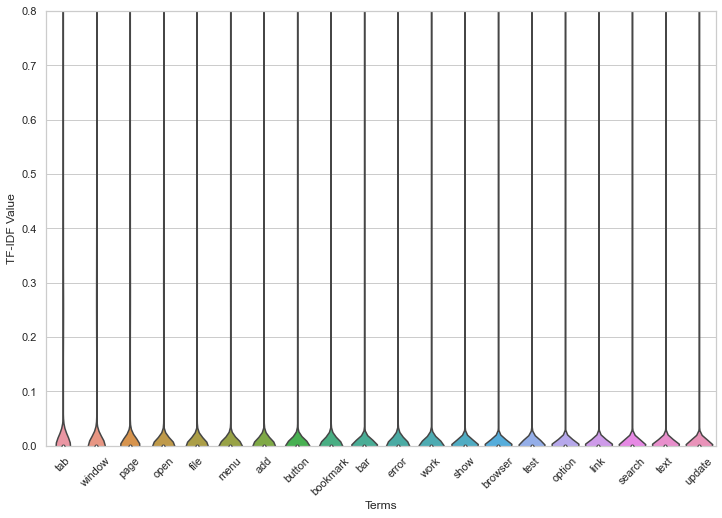

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert TF-IDF matrix to dense array if it's not already
if not isinstance(tfidf_matrix, np.ndarray):
    tfidf_matrix_dense = tfidf_matrix.toarray()
else:
    tfidf_matrix_dense = tfidf_matrix

o_tfidf = {}

for i in range(len(df3)):
    for j, word in enumerate(feature_names):
        if word not in o_tfidf:
            o_tfidf[word] = []
        tfidf_score = tfidf_matrix_dense[i, j]
        o_tfidf[word].append(tfidf_score)

# Convert object to data frame
df_tfidf = pd.DataFrame(o_tfidf)

# Compute the average TF-IDF score for each term
avg_tfidf = df_tfidf.mean().sort_values(ascending=False)

# Select the top 20 terms
top_20_terms = avg_tfidf.head(20).index

# Filter the dataframe to include only the top 20 terms
df_tfidf_top_20 = df_tfidf[top_20_terms]

# Determine the range of TF-IDF values for the top 20 terms
min_val = df_tfidf_top_20.min().min()
max_val = df_tfidf_top_20.max().max()

# Set the style of the plot
sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))
# Create the violin plot for the top 20 terms
sns.violinplot(data=df_tfidf_top_20)

# Set labels for the axes
plt.xlabel("Terms")
plt.ylabel("TF-IDF Value")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Adjust the y-axis limits to zoom in on the data
plt.ylim(min_val, max_val)

# Show the plot
plt.show()


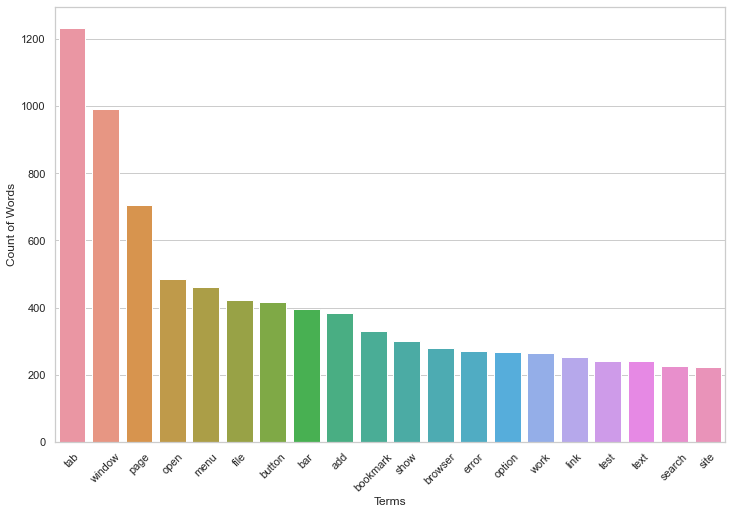

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming you've already converted the tfidf_matrix to a dense format

# Convert TF-IDF matrix to DataFrame
df_tfidf = pd.DataFrame(tfidf_matrix, columns=feature_names)

# Count the number of non-zero TF-IDF scores for each term
word_counts = df_tfidf.gt(0).sum().sort_values(ascending=False)

# Select the top 20 terms
top_20_terms = word_counts.head(20)

# Set the style of the plot
sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))
# Create the bar plot for the top 20 terms
sns.barplot(x=top_20_terms.index, y=top_20_terms.values)

# Set labels for the axes
plt.xlabel("Terms")
plt.ylabel("Count of Words")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()
